## <center> Go to piazza and open today's lecture notes in the hub! </center>
## <center> https://piazza.com/class/jzioyk40mhs6r2 </center>
## <center> Let's go to tophat for attendance! </center>
## <center> https://app.tophat.com/e/245218 </center>

### <center>Mud card</center>

- **What to do if we know that the catgeories of a feature are ordered but integers from 0 to n_cats - 1 are not the best way to represent them?**
   - didn't find a simple way to do this with sklearn.
   - a pandas solution: `df['column'].replace(to_replace=['cat1','cat2','cat3','cat4'],value=[0,1,4,6])`
- **I am trying to get an intuitive understanding of what transformation means. have we done machine learning at this point or still in preprocessing?**
   - Some supervised ML algorithms assume that all features are centered around 0 and have a variance in the same order of magnitude
   - you achieve this with transformations (an often linear function applied to the feature)
   

- **if you have a dataset that is constantly changing and you want to keep updating your model, how do you go about this?**
   - you can add new data to your training set
   - every time you update X_train, you need to re-fit the preprocessors and re-transform the test
   - basically you need to rerun the whole ML pipeline
- **when we transform the training data, why would the transformer raise a value error that reads into the test data and raise that "firefox" is an unknown category?**
   - the transformer only knows about the categories that it sees in the dataset it was fit on (X_train). 
   - so a category that first appears in X_test is unknown to the transformer.
   

- **I'm unsure what label encoder does? How does labelencoder classify the labels?**
   - labelencoder doesn't classify the labels, it transforms them.
   - if you work on a classification problem, scikit-learn expects your classification labels to be integers from 0 to n_classes - 1
   - if this is not the case (e.g., the classes  are encoded as strings or  numbers outside of the range 0 to n_classes - 1), the label encoder tranforms the label to the proper format.
- **Why isn't there a problem of multicollinearity with one-hot encoder? since when working with dummy variables, you have to leave out a category as your reference category.**
   - if there is a problem, you can use OneHotEncoder's `drop` parameter to leave out one category.

# <center> Data preprocessing, part 2, missing data </center>
### By the end of this lecture, you will be able to
- Describe and compare the three main types of missingness patterns
- Evaluate simple approaches for handling missing values
- Apply multivariate imputation to a dataset



## Missing values often occur in datasets
- survey data: not everyone answers all the questions
- medical data: not all tests/treatments/etc are performed on all patients
- sensor can be offline or malfunctioning
- customer data: not every user uses all features of an app

## Missing values are an issue for multiple reasons

#### Concenptual reason
- missing values can introduce biases
    - bias: the samples (the data points) are not representative of the underlying distribution/population
    - any conclusion drawn from a biased dataset is also biased.
    - rich people tend to not fill out survey questions about their salaries and the mean salary estimated from survey data tend to be lower than true value


#### Practical reason
- missing values (NaN, NA, inf) are incompatible with sklearn
   - all values in an array need to be numerical otherwise sklearn will throw a *ValueError*
- there are a few supervised ML techniques that work with missing values (e.g., XGBoost)
   - we will cover those later this semester during a follow-up lecture on missing data

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Describe and compare the three main types of missingness patterns**
- <font color='LIGHTGRAY'>Evaluate simple approaches for handling missing values</font>
- <font color='LIGHTGRAY'>Apply multivariate imputation to a dataset</font>


# Missing data patterns

- MCAR - Missing Complete At Random
- MAR - Missing At Random
- MNAR - Missing Not At Random

## MCAR - Missing Complete At Random

- the reason the values are missing are related to an unobserved (unimportant) variable
   - the data sample is still representative of the underlying distribution/population
- your best case scenario but usually rare
- can be diagnosed with a statistical test ([Little, 1988](https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722))
   - pdf of article in folder, python implementation [here](https://github.com/RianneSchouten/pymice)

## MCAR examples
- some people randomly fail to fill in some values in a survey 
- sensor randomly malfunctions
- apps, websites are unavailable sometimes

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# generate the data
n_samples = 500
X, y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2,
                           random_state=10, n_clusters_per_class=1,class_sep=0.5)

def plot_res(X,y,cmap,title,xlim,ylim):
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k',cmap=cmap)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.title(title)
    return

xlim = [np.min(X[:, 0]),np.max(X[:, 0])]
ylim = [np.min(X[:, 1]),np.max(X[:, 1])]

plt.figure(figsize=(4.8*2,3.6))
plt.subplot(121) 
plot_res(X,y,cmap='summer',title='full dataset',xlim=xlim,ylim=ylim)

indcs = np.random.choice(np.arange(n_samples),size=int(n_samples/3),replace=False)
X_ampute = np.copy(X)
X_ampute[indcs,0] = np.nan

plt.subplot(122) 
plot_res(X_ampute,y,cmap='summer',title='MCAR',xlim=xlim,ylim=ylim)

plt.tight_layout()
plt.savefig('figures/MCAR.png',dpi=300)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MCAR.csv',index=False)



<center><img src="figures/MCAR.png" width="800"></center>

## MAR - Missing At Random

- Name is misleading! Better name would be 'Missing Conditionally at Random' but the MCAR acronym is taken. 
- the reason why feature_i contains missing values is conditional on other variables but not on feature_i
- difficult to diagnose
- still, most methods assume MAR

## MAR examples
- missing value in blood pressure data conditional on age
   - older people are more likely to have their blood pressure measured during a regular check-up than younger people
- males are less likely to fill in a depression survey
   - this has nothing to do with their level of depression after accounting for maleness

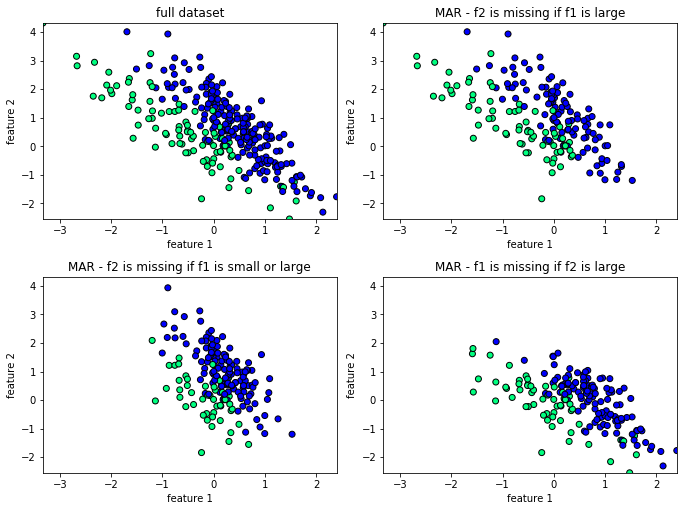

In [2]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# generate the data
n_samples = 300
X, y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2,
                           random_state=3, n_clusters_per_class=1,class_sep=0.5,weights=[0.7,0.3])

xlim = [np.min(X[:, 0]),np.max(X[:, 0])]
ylim = [np.min(X[:, 1]),np.max(X[:, 1])]

plt.figure(figsize=(4.8*2,3.6*2))

plt.subplot(221) 
plot_res(X,y,cmap='winter',title='full dataset',xlim=xlim,ylim=ylim)

f1_scaled = (MinMaxScaler().fit_transform(2**X[:, 0].reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.4),replace=False,p=f1_scaled/np.sum(f1_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,1] = np.nan 
plt.subplot(222) 
plot_res(X_ampute,y,cmap='winter',title='MAR - f2 is missing if f1 is large',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MAR1.csv',index=False)


f1_scaled = (MinMaxScaler().fit_transform(2**np.abs(X[:, 0]).reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.4),replace=False,p=f1_scaled/np.sum(f1_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,1] = np.nan 
plt.subplot(223) 
plot_res(X_ampute,y,cmap='winter',title='MAR - f2 is missing if f1 is small or large',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MAR2.csv',index=False)


f2_scaled = (MinMaxScaler().fit_transform(2**X[:, 1].reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.4),replace=False,p=f2_scaled/np.sum(f2_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,0] = np.nan 
plt.subplot(224) 
plot_res(X_ampute,y,cmap='winter',title='MAR - f1 is missing if f2 is large',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MAR3.csv',index=False)

df = pd.DataFrame()
df['feature 1'] = X[:,0]
df['feature 2'] = X[:,1]
df['label'] = y
df.to_csv('data/complete_MAR.csv',index=False)


plt.tight_layout()
plt.savefig('figures/MAR.png',dpi=300)
plt.show()



<center><img src="figures/MAR.png" width="800"></center>

## MNAR - Missing Not At Random

- the reason the variable is missing is related to the value of the variable itself
- most severe case of missingness!
- not many approaches can deal with this correctly

## MNAR examples
- depressed people are less likely to fill out a survey on depression because of their level of depression
- rich people don't fill out survey info on  their salaries because they are rich
- temperature sensor doesn't work because the observed temperature is outside of range

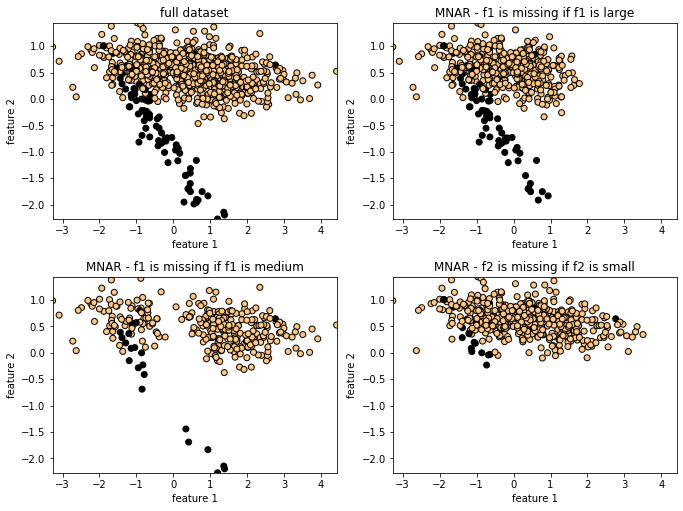

[[ 0.50330491  0.75509089]
 [-1.25836825  0.63606317]
 [-0.46424533  0.39416046]
 ...
 [-0.63962288         nan]
 [ 0.75312171         nan]
 [-0.2220152          nan]]


In [3]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# generate the data
n_samples = 800
X, y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2,
                           random_state=16, n_clusters_per_class=1,class_sep=0.5,weights=[0.1,0.9])

xlim = [np.min(X[:, 0]),np.max(X[:, 0])]
ylim = [np.min(X[:, 1]),np.max(X[:, 1])]

plt.figure(figsize=(4.8*2,3.6*2))

plt.subplot(221) 
plot_res(X,y,cmap='copper',title='full dataset',xlim=xlim,ylim=ylim)

f1_scaled = (MinMaxScaler().fit_transform(2**X[:, 0].reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.4),replace=False,p=f1_scaled/np.sum(f1_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,0] = np.nan 
plt.subplot(222) 
plot_res(X_ampute,y,cmap='copper',title='MNAR - f1 is missing if f1 is large',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MNAR1.csv',index=False)


f1_scaled = (MinMaxScaler().fit_transform(2**(-1*np.abs(X[:, 0])).reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.6),replace=False,p=f1_scaled/np.sum(f1_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,0] = np.nan 
plt.subplot(223) 
plot_res(X_ampute,y,cmap='copper',title='MNAR - f1 is missing if f1 is medium',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MNAR2.csv',index=False)


f2_scaled = (MinMaxScaler().fit_transform(2**(-1*X[:, 1]).reshape(-1, 1))[:,0])**2
indcs = np.random.choice(np.arange(n_samples),size=int(n_samples*0.4),replace=False,p=f2_scaled/np.sum(f2_scaled))
X_ampute = np.copy(X)
X_ampute[indcs,1] = np.nan 
plt.subplot(224) 
plot_res(X_ampute,y,cmap='copper',title='MNAR - f2 is missing if f2 is small',xlim=xlim,ylim=ylim)

df = pd.DataFrame()
df['feature 1'] = X_ampute[:,0]
df['feature 2'] = X_ampute[:,1]
df['label'] = y
df.to_csv('data/MNAR3.csv',index=False)

df = pd.DataFrame()
df['feature 1'] = X[:,0]
df['feature 2'] = X[:,1]
df['label'] = y
df.to_csv('data/complete_MNAR.csv',index=False)



plt.tight_layout()
plt.savefig('figures/MNAR.png',dpi=300)
plt.show()

print(X_ampute)

<center><img src="figures/MNAR.png" width="800"></center>

## Takeaway
- missingness patterns can be imposed on complete datasets
- it can be challenging to infer the missingness pattern from an incomplete dataset
   - There is a statistical test to diagnose MCAR
   - MAR and MNAR are difficult/impossible to diagnose

## Exercise 1
MCAR, MAR or MNAR?


### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe and compare the three main types of missingness patterns</font>
- **Evaluate simple approaches for handling missing values**
- <font color='LIGHTGRAY'>Apply multivariate imputation to a dataset</font>


## Simple approaches for handling missing values

- exclude points or features with missing values
- categorical feature: treat missing values as another category
- continuous feature: sklearn's SimpleImputer


### Exclude points or features with missing values
- easy to do with pandas
- it is an ACCEPTABLE approach under two conditions:
    - Little's test supports MCAR (p > 0.05)
    - only small fraction of points contain missing values (maybe a few percent?)
    
- if the MCAR assumption is justified, dropping points will not introduce biases to your model
- due to the smaller sample size, the confidence of your model might suffer. 


##### How to check the fraction of missing values per row and column?

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/adult_data.csv')
# missing values are represented as ' ?' in the dataset
# let's replace that with np.nan
df.replace(to_replace=' ?',value = np.nan, inplace=True)

print(df.shape)
print(df.isnull().sum(axis=0)/df.shape[0])
print(sum(df.isnull().sum(axis=1)!=0)/df.shape[0])

(32561, 15)
age               0.000000
workclass         0.056386
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.056601
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.017905
gross-income      0.000000
dtype: float64
0.07367709836921471


##### Drop points or features with missing values

In [5]:
print(df.shape)
# by default, rows/points are dropped
df_r = df.dropna()
print(df_r.shape)
# drop features with missing values
df_c = df.dropna(axis=1)
print(df_c.shape)


(32561, 15)
(30162, 15)
(32561, 12)


### Categorical feature: treat missing values as another category

- the BEST thing you can do!
- already covered in the preprocessing lecture (one hot encoding)
- example: missing values in gender
    - if survey only has options for male/female, missing values are likely because those people are outside the gender binary
    - it is a bad idea to impute (try to guess male or female and thus boxing them into the binary)
- example: native country in the adult data
    - missing data are represented as ` ?`
    - a one-hot encoded feature was assigned to the missing category


### Continuous feature: sklearn's SimpleImputer

- Imputation means you infer the missing values from the known part of the data
- sklearn's SimpleImputer can do mean and median imputation
- USUALLY A BAD IDEA!
   - MCAR: mean/median of non-missing values is the same as the mean/median of the true underlying distribution, but the variances are different
   - not MCAR: the mean/median and the variance of the completed dataset will be off
   - supervised ML model is too confident (MCAR) or systematically off (not MCAR)

In [6]:
from sklearn.impute import SimpleImputer
help(SimpleImputer)

Help on class SimpleImputer in module sklearn.impute._base:

class SimpleImputer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Imputation transformer for completing missing values.
 |  
 |  Read more in the :ref:`User Guide <impute>`.
 |  
 |  Parameters
 |  ----------
 |  missing_values : number, string, np.nan (default) or None
 |      The placeholder for the missing values. All occurrences of
 |      `missing_values` will be imputed.
 |  
 |  strategy : string, optional (default="mean")
 |      The imputation strategy.
 |  
 |      - If "mean", then replace missing values using the mean along
 |        each column. Can only be used with numeric data.
 |      - If "median", then replace missing values using the median along
 |        each column. Can only be used with numeric data.
 |      - If "most_frequent", then replace missing using the most frequent
 |        value along each column. Can be used with strings or numeric data.
 |      - If "constant", then replac

## Exercise 2: True of False?

- MAR and MNAR can be distinguished based on the dataset.
- Dropping points with missing values is OK, if the p value of Little's test larger than 0.05 and only a small fraction  of the data points contain missing values.
- If people don't fill out a survey question about that salaries because they are rich, that's MAR.

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe and compare the three main types of missingness patterns</font>
- <font color='LIGHTGRAY'>Evaluate simple approaches for handling missing values</font>
- **Apply multivariate imputation to a dataset**


## Multivariate imputation

- models each feature with missing values as a function of other features, and uses that estimate for imputation
   - at each step, a feature column is designated as target variable y and the other feature columns are treated as inputs X
   - a regressor is trained on (X, y) for known y
   - then, the regressor is used to predict the missing values of y
- works for MCAR and MAR
- fails for MNAR
- paper [here](https://www.jstatsoft.org/article/view/v045i03) and pdf in folder

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
help(IterativeImputer)

Help on class IterativeImputer in module sklearn.impute._iterative:

class IterativeImputer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Multivariate imputer that estimates each feature from all the others.
 |  
 |  A strategy for imputing missing values by modeling each feature with
 |  missing values as a function of other features in a round-robin fashion.
 |  
 |  Read more in the :ref:`User Guide <iterative_imputer>`.
 |  
 |  .. note::
 |  
 |    This estimator is still **experimental** for now: the predictions
 |    and the API might change without any deprecation cycle. To use it,
 |    you need to explicitly import ``enable_iterative_imputer``::
 |  
 |      >>> # explicitly require this experimental feature
 |      >>> from sklearn.experimental import enable_iterative_imputer  # noqa
 |      >>> # now you can import normally from sklearn.impute
 |      >>> from sklearn.impute import IterativeImputer
 |  
 |  Parameters
 |  ----------
 |  estimator : estimato

In [8]:
# let's impute exercise1a.csv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


df = pd.read_csv('data/exercise1a.csv')

X = df[['feature 1','feature 2']].values
print(X[:10])

y = df['label'].values
imputer = IterativeImputer(random_state=5)
X_impute = imputer.fit_transform(X)

print(X_impute[:10])

[[ 1.01120706 -1.47656266]
 [-0.33128317  0.38653915]
 [ 1.2179409          nan]
 [ 0.98633519  0.2135339 ]
 [ 0.92550121 -0.45698786]
 [ 1.16033857  0.36949272]
 [-1.53879325         nan]
 [-1.55694156 -0.61244213]
 [-0.77785883  1.11584111]
 [-2.08639057         nan]]
[[ 1.01120706 -1.47656266]
 [-0.33128317  0.38653915]
 [ 1.2179409   0.02505578]
 [ 0.98633519  0.2135339 ]
 [ 0.92550121 -0.45698786]
 [ 1.16033857  0.36949272]
 [-1.53879325  0.15463907]
 [-1.55694156 -0.61244213]
 [-0.77785883  1.11584111]
 [-2.08639057  0.18037948]]


## Multivariate imputation: uncertainty estimate

- create multiple imputed datasets with different random seeds (at least 3)
- run each imputed dataset through your ML pipeline
- measure the uncertainty of the predicted target variable (mean and stdev of each points' predicted labels)

## Exercise 3
- Create five different imputed datasets for exercise1b.csv!


In [9]:
# add your code here!


### Now you can
- Describe and compare the three main types of missingness patterns
- Evaluate simple approaches for handling missing values
- Apply multivariate imputation to continuous features in a dataset

